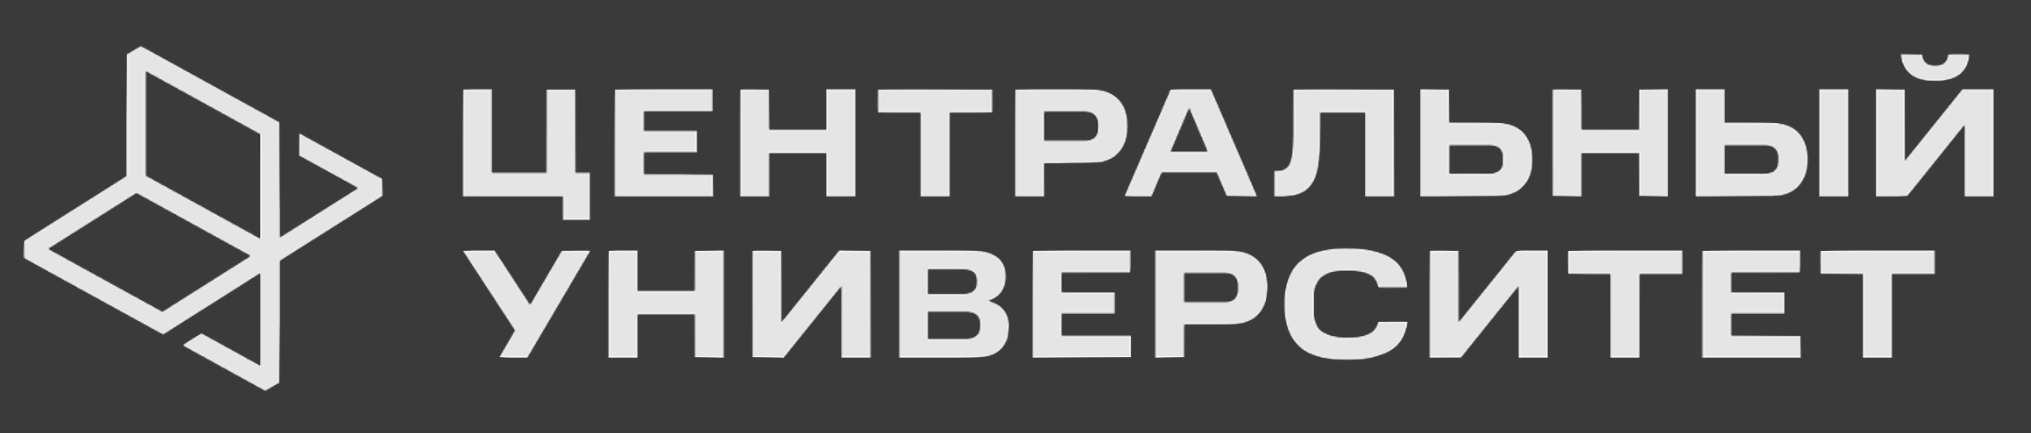

**Постановка задачи**

---



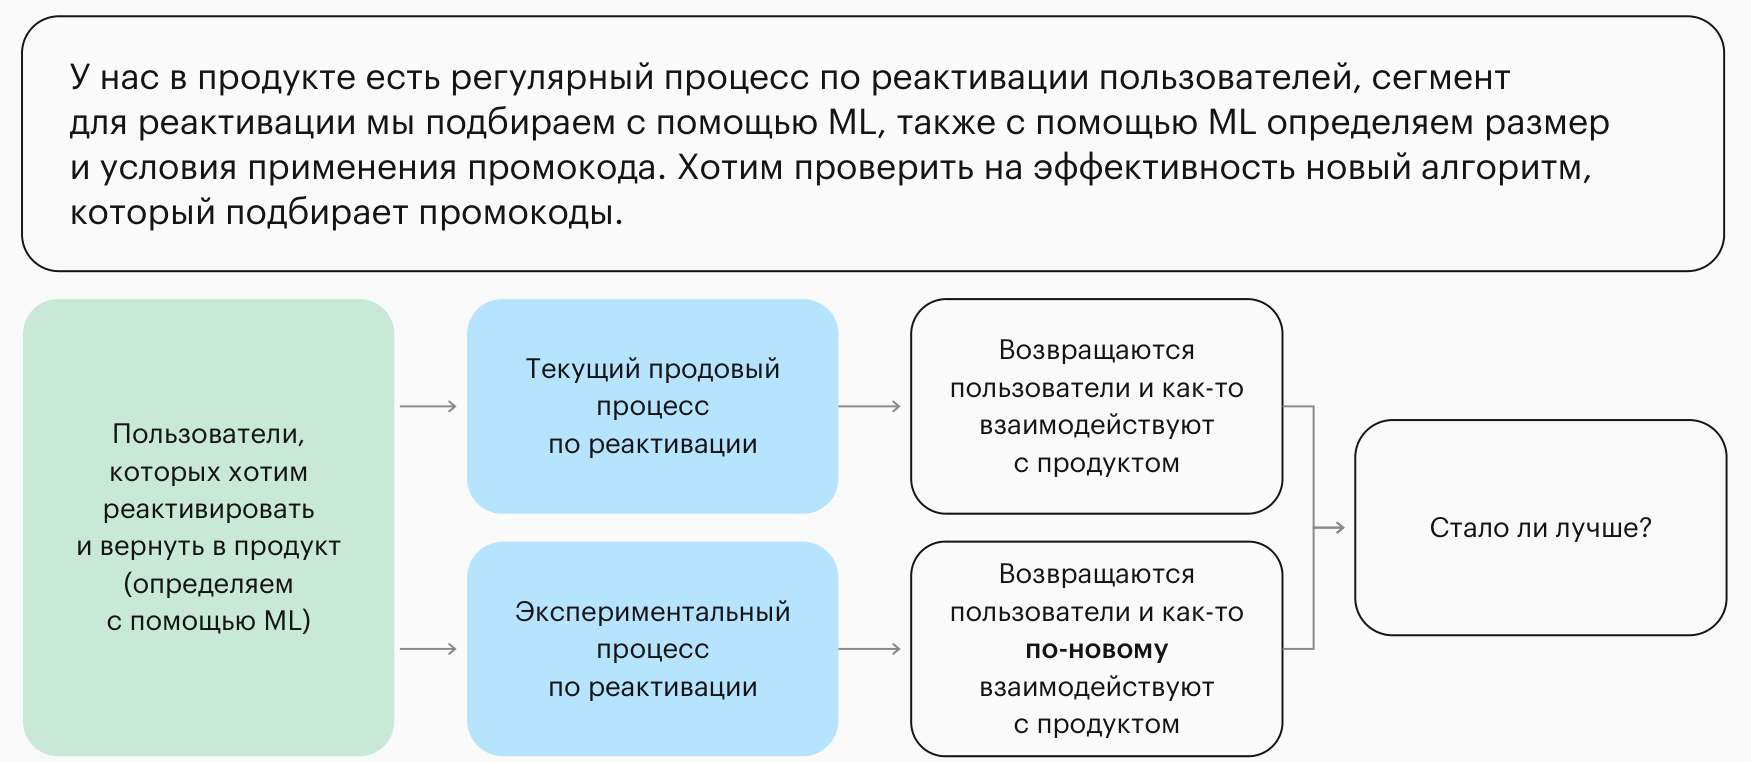

# День 1. Работа с данными на предпериоде

❓Задание:

> Необходимо отобрать заказы с 2024-11-22 по 2024-12-12 со статусом order_state 'complete' и 'canceled' и посчитать пользовательские сигналы

In [ ]:
# @title Отфильтрованный датасет
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.style.use('ggplot')

orders_df = pd.read_csv("https://drive.google.com/uc?export=download&id=10Tktdi0AphjCp7EwBedhC6v53Le1gzff")

# Преобразуем 'completed_at' в datetime объекты
orders_df['completed_at'] = pd.to_datetime(orders_df['completed_at'])

# Определяем период для фильтрации
start_date = pd.to_datetime('2024-11-22')
end_date = pd.to_datetime('2024-12-12')

# Отбираем заказы с 2024-11-22 по 2024-12-12 со статусом 'complete' или 'canceled'
filtered_orders = orders_df[
    (orders_df['completed_at'] >= start_date) &
    (orders_df['completed_at'] <= end_date) &
    (orders_df['order_state'].isin(['complete', 'canceled']))
].copy() # Добавляем .copy() для избежания предупреждения SettingWithCopyWarning

filtered_orders.head()

,completed_at,completed_at_ts,user_id,order_id,gmv_net_of_promo,promo,order_state,new_or_repeated
2,2024-12-10 15:28:05,1733844485,U_e094439a0bd07d4e3904af196576c5ca,O_01cc71017bd4f4204aa22b3b01daee1b,1928.00,0.0,complete,repeated
6,2024-12-07 20:02:10,1733601730,U_29ace71129a52dfe1988097bc2f2d7e3,O_0aa4c5b8e584f1677e3cbf650073319c,593.00,0.0,complete,repeated
13,2024-12-03 19:33:32,1733254412,U_56a93d50c75b93287d5ba2c048e8cb00,O_0744ccbf3fb478639169f1b9826e0a13,1586.00,0.0,complete,repeated
16,2024-12-07 20:19:51,1733602791,U_bea7c9d9a86a9e27020c18e9ae491825,O_d679a6a09ac33d2b4e6bcef725fe00ff,3713.21,0.0,complete,repeated
23,2024-12-04 15:20:30,1733325630,U_e7028826d5d4bacb4f5d1a169bf178ec,O_f4827096743d26f4f5f7986a3325afe6,2040.42,0.0,complete,repeated


**Описание пользовательских сигналов**

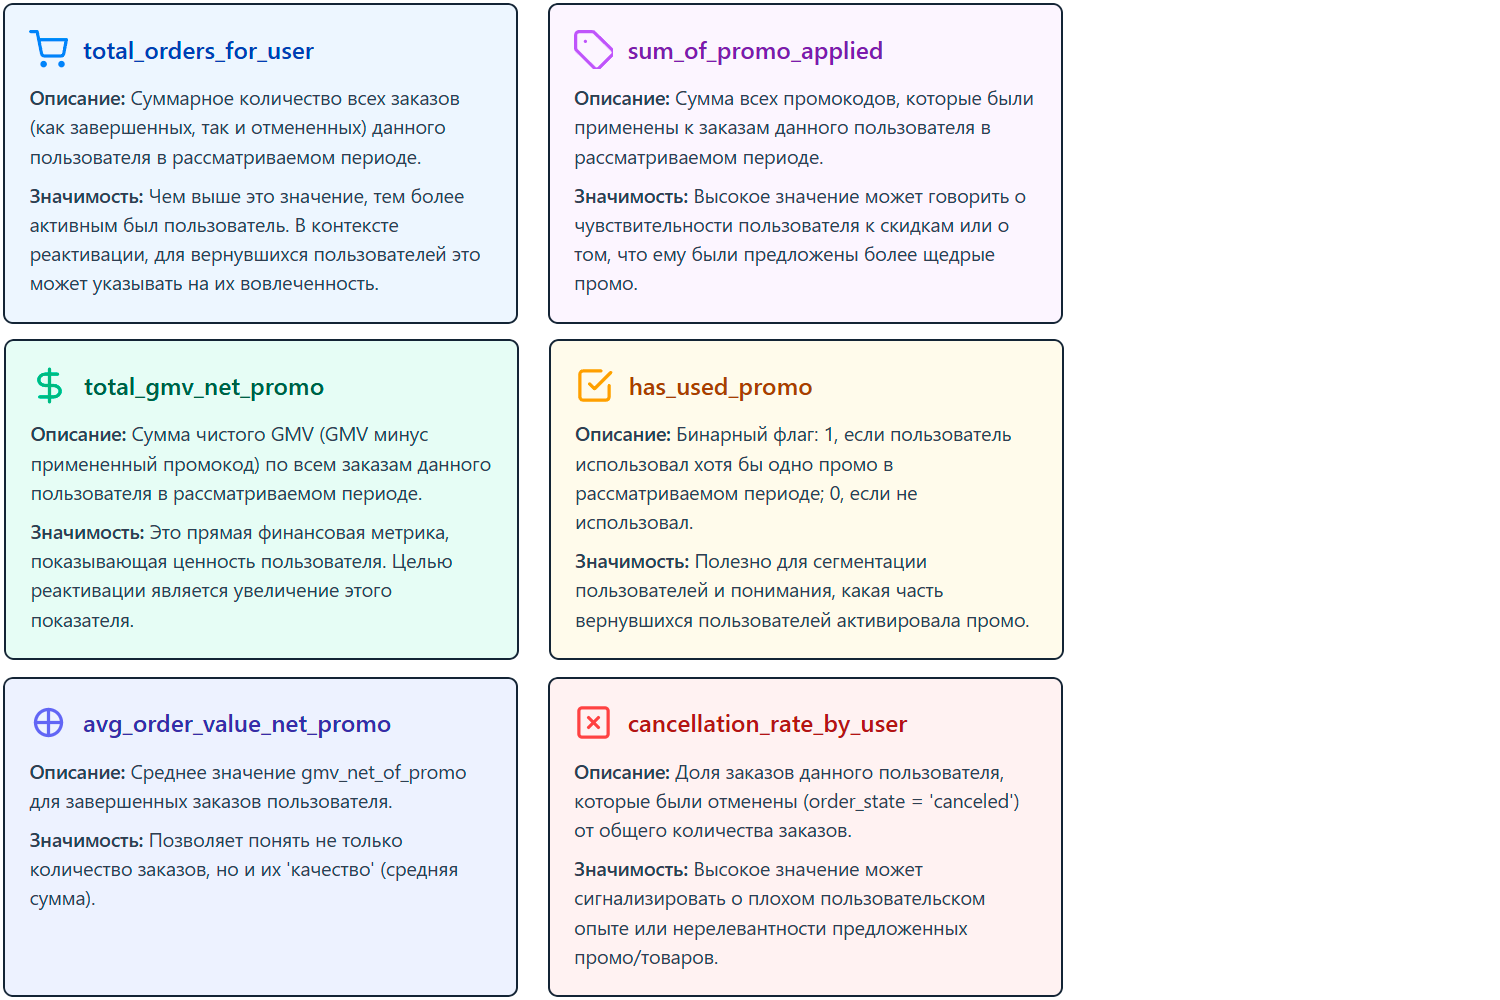

In [ ]:
# @title Агрегация по 'user_id' и расчет пользовательских сигналов

user_metrics_df = filtered_orders.groupby('user_id').agg(
    # Общее количество всех заказов пользователя в выбранном периоде
    total_orders_for_user=('order_id', 'count'),
    # Общая сумма примененных промокодов для пользователя
    sum_of_promo_applied=('promo', 'sum'),
    # Валовый объем продаж (GMV) для пользователя за вычетом промо
    total_gmv_net_promo=('gmv_net_of_promo', 'sum'),
    # Флаг: 1, если пользователь использовал хотя бы одно промо, 0 в противном случае
    has_used_promo=('promo', lambda x: (x > 0).any().astype(int)),
    # Количество отмененных заказов пользователя
    canceled_orders_by_user=('order_state', lambda x: (x == 'canceled').sum()),
    # Количество успешно завершенных заказов пользователя
    completed_orders_by_user=('order_state', lambda x: (x == 'complete').sum())
).reset_index()

# Заполняем потенциальные пропущенные значения (например, если какая-то агрегация пуста) нулями
user_metrics_df = user_metrics_df.fillna(0)

# Приводим типы данных к оптимальным (целые для счетчиков, float для денежных сумм)
user_metrics_df = user_metrics_df.astype({
    'total_orders_for_user': int,
    'sum_of_promo_applied': float, # Промо может быть дробным, поэтому float
    'total_gmv_net_promo': float,
    'has_used_promo': int,
    'canceled_orders_by_user': int,
    'completed_orders_by_user': int
})

# Средний чек (Average Order Value - AOV) пользователя: total_gmv_net_promo / completed_orders_by_user
user_metrics_df['avg_order_value_net_promo'] = np.where(
    user_metrics_df['completed_orders_by_user'] > 0,
    user_metrics_df['total_gmv_net_promo'] / user_metrics_df['completed_orders_by_user'],
    0
)

# Доля отмененных заказов (Cancellation Rate) пользователя: canceled_orders_by_user / total_orders_for_user
user_metrics_df['cancellation_rate_by_user'] = np.where(
    user_metrics_df['total_orders_for_user'] > 0,
    user_metrics_df['canceled_orders_by_user'] / user_metrics_df['total_orders_for_user'],
    0
)

# Сортируем результат для удобства просмотра
user_metrics_df = user_metrics_df.sort_values('user_id')

user_metrics_df.head()

,user_id,total_orders_for_user,sum_of_promo_applied,total_gmv_net_promo,has_used_promo,canceled_orders_by_user,completed_orders_by_user,avg_order_value_net_promo,cancellation_rate_by_user
0,U_00024bcba5638d9c0a504ef7dd58b41c,1,0.00,282.33,0,0,1,282.33,0.0
1,U_0002a234ca06e3e2d7af7d7a7789bfd3,1,123.95,317.81,1,0,1,317.81,0.0
2,U_0002c29eacf17d0799bd7ce65f9a323a,1,0.00,302.16,0,0,1,302.16,0.0
3,U_0004da139a0ba2d5487271d64d7073b5,1,0.00,2898.18,0,0,1,2898.18,0.0
4,U_0007de9e6d6c913691eea121569204fb,1,150.24,3000.29,1,0,1,3000.29,0.0


# **День 2. Дизайн A/B теста**

---

❓Задание:
> - Сформулировать нулевую (H0) и альтернативную (H1) гипотезы
- Придумать и описать ключевые метрики
- Придумтаь и описать приемочные метрики
- Рассчитать MDE (Minimum Detectable Effect) и MDE (%) для каждой метрики



**1. Цель теста:**
Оценить влияние нового алгоритма подбора промокодов для реактивации пользователей на их возвращение, активность и общие доходы, а также убедиться, что нововведение не оказывает негативного влияния на ключевые бизнес-показатели и лояльность пользователей.

**2. Метрики для теста**

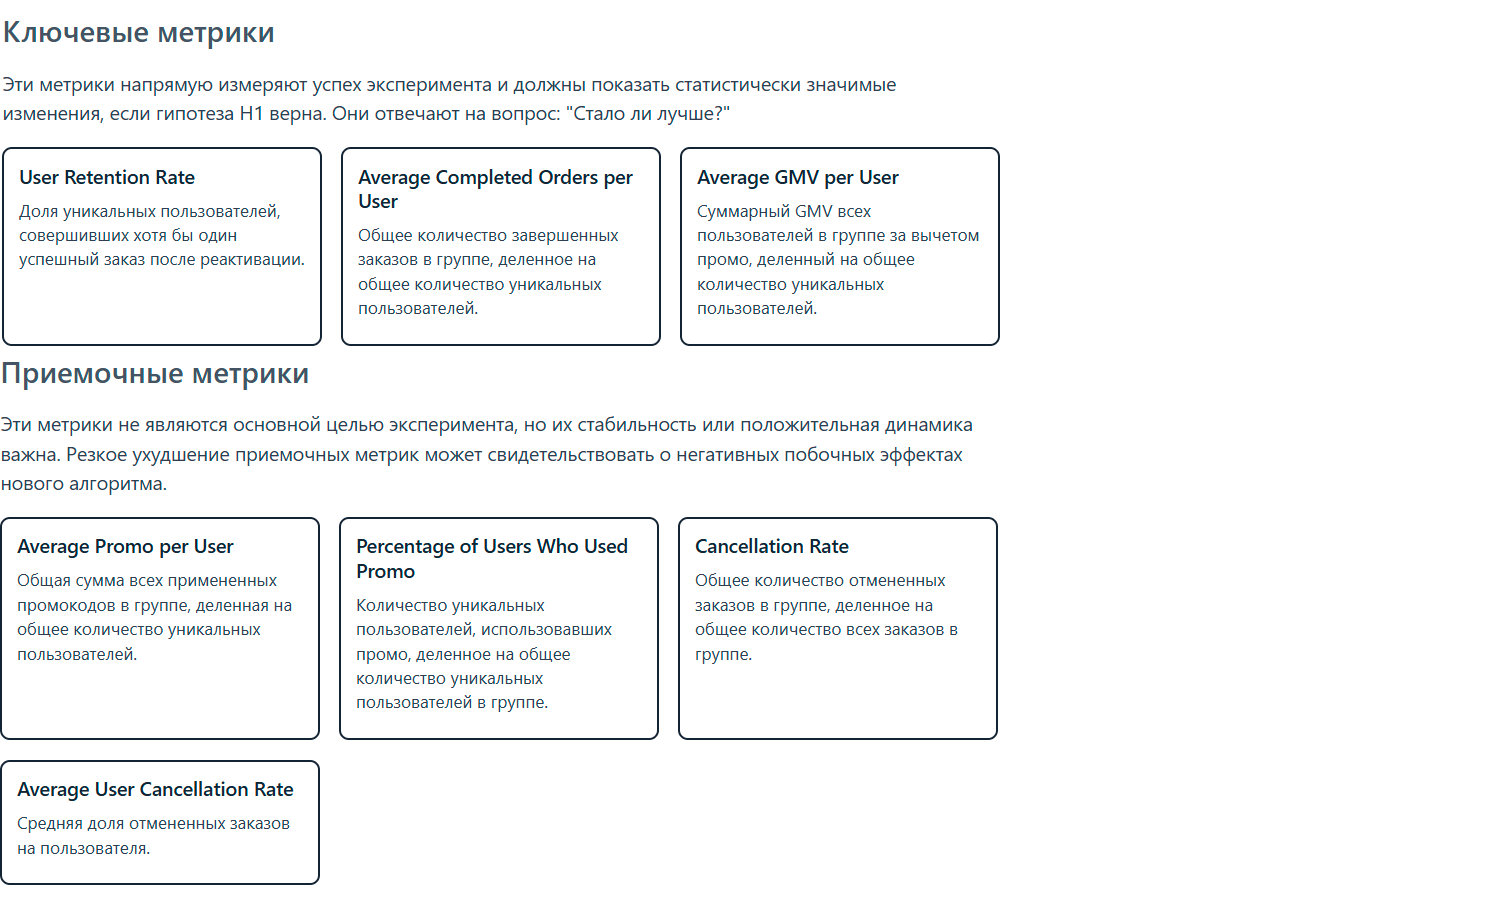

**3. Гипотезы:**

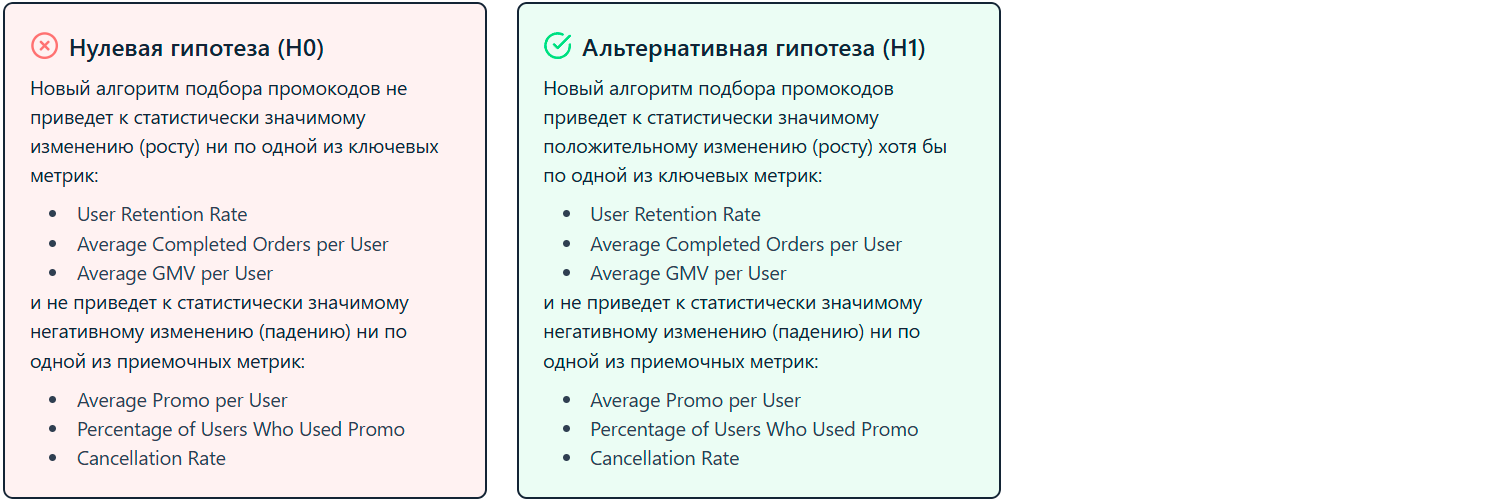

**4. Группы теста:**

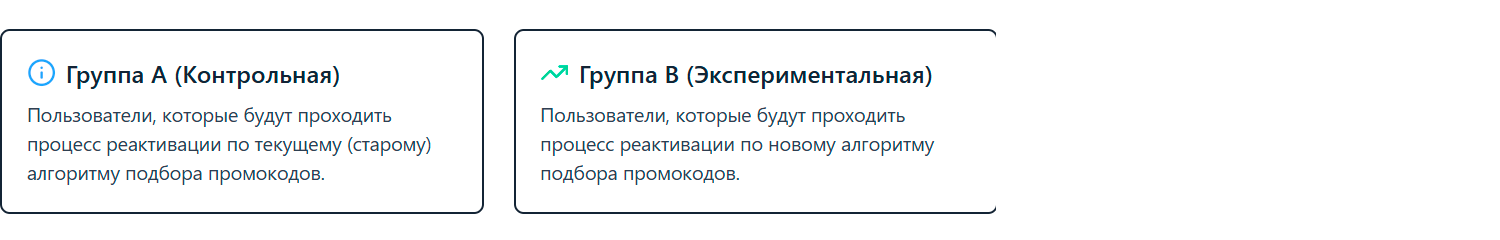



**5. Критериии принятия решения:**

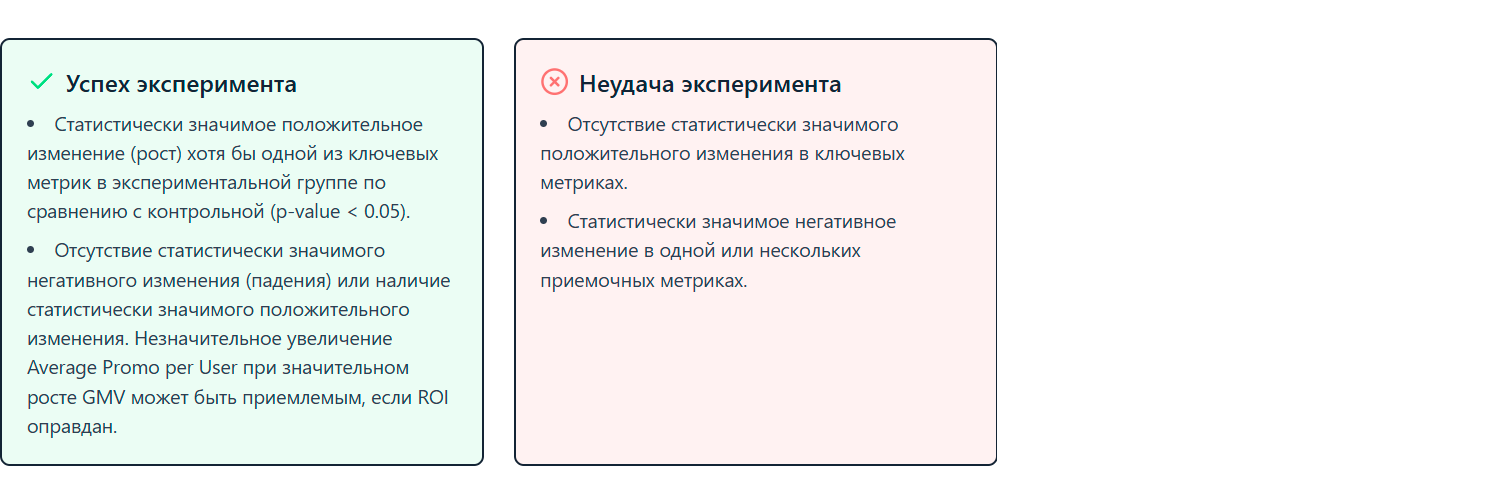

In [ ]:
# @title **Расчет MDE**
# Функция для расчета MDE
def get_mde(samp_var, n):
    """
    Рассчитывает Minimum Detectable Effect (MDE) по заданной формуле.
    samp_var: дисперсия метрики в выборке (контрольной группе)
    n: размер выборки (количество пользователей в группе)
    """
    if n == 0:
        return np.nan
    return np.sqrt((16 * samp_var) / n)

# Размер выборки (количество пользователей в контрольной группе)
n_control = user_metrics_df['user_id'].nunique()

# Список для хранения результатов MDE в формате словарей
mde_results_list = []


# 1. Процент вернувшихся пользователей (User Retention Rate)
# Считаем, сколько пользователей совершили хотя бы 1 завершенный заказ
reactivated_users_count = user_metrics_df[user_metrics_df['completed_orders_by_user'] > 0].shape[0]
retention_rate = reactivated_users_count / n_control
# Для бинарной метрики (0 или 1 - вернулся/не вернулся) дисперсия = p * (1-p)
retention_rate_var = retention_rate * (1 - retention_rate)
mde_retention = get_mde(retention_rate_var, n_control)
mde_retention_perc = (mde_retention / retention_rate) * 100 if retention_rate > 0 else np.nan
mde_results_list.append({
    'Метрика': 'User Retention Rate',
    'Базовое значение': f"{retention_rate:.4f} ({retention_rate*100:.2f}%)",
    'Дисперсия': f"{retention_rate_var:.4f}",
    'MDE (абс.)': f"{mde_retention:.4f}",
    'MDE (%)': f"{mde_retention_perc:.2f}%"
})

# 2. Среднее количество завершенных заказов на пользователя (Average Completed Orders per User)
avg_completed_orders_per_user = user_metrics_df['completed_orders_by_user'].mean()
var_completed_orders_per_user = user_metrics_df['completed_orders_by_user'].var() # Дисперсия
mde_avg_completed_orders = get_mde(var_completed_orders_per_user, n_control)
mde_avg_completed_orders_perc = (mde_avg_completed_orders / avg_completed_orders_per_user) * 100 if avg_completed_orders_per_user > 0 else np.nan
mde_results_list.append({
    'Метрика': 'Avg Completed Orders per User',
    'Базовое значение': f"{avg_completed_orders_per_user:.2f}",
    'Дисперсия': f"{var_completed_orders_per_user:.2f}",
    'MDE (абс.)': f"{mde_avg_completed_orders:.2f}",
    'MDE (%)': f"{mde_avg_completed_orders_perc:.2f}%"
})

# 3. Средний GMV на пользователя (Average GMV per User)
avg_gmv_per_user = user_metrics_df['total_gmv_net_promo'].mean()
var_gmv_per_user = user_metrics_df['total_gmv_net_promo'].var() # Дисперсия
mde_avg_gmv = get_mde(var_gmv_per_user, n_control)
mde_avg_gmv_perc = (mde_avg_gmv / avg_gmv_per_user) * 100 if avg_gmv_per_user > 0 else np.nan
mde_results_list.append({
    'Метрика': 'Average GMV per User',
    'Базовое значение': f"{avg_gmv_per_user:.2f}",
    'Дисперсия': f"{var_gmv_per_user:.2f}",
    'MDE (абс.)': f"{mde_avg_gmv:.2f}",
    'MDE (%)': f"{mde_avg_gmv_perc:.2f}%"})

# Код для расчета приемочных метрик контрольной группы
# 1. Средний размер промо на пользователя (Average Promo per User)
avg_promo_per_user = user_metrics_df['sum_of_promo_applied'].mean()
var_promo_per_user = user_metrics_df['sum_of_promo_applied'].var() # Дисперсия
mde_avg_promo = get_mde(var_promo_per_user, n_control)
mde_avg_promo_perc = (mde_avg_promo / avg_promo_per_user) * 100 if avg_promo_per_user > 0 else np.nan
mde_results_list.append({
    'Метрика': 'Average Promo per User',
    'Базовое значение': f"{avg_promo_per_user:.2f}",
    'Дисперсия': f"{var_promo_per_user:.2f}",
    'MDE (абс.)': f"{mde_avg_promo:.2f}",
    'MDE (%)': f"{mde_avg_promo_perc:.2f}%"
})

# 2. Доля пользователей, использовавших промо (Percentage of Users Who Used Promo)
perc_users_used_promo = user_metrics_df['has_used_promo'].mean()
perc_users_used_promo_var = perc_users_used_promo * (1 - perc_users_used_promo)
mde_perc_users_promo = get_mde(perc_users_used_promo_var, n_control)
mde_perc_users_promo_perc = (mde_perc_users_promo / perc_users_used_promo) * 100 if perc_users_used_promo > 0 else np.nan
mde_results_list.append({
    'Метрика': 'Percentage of Users Who Used Promo',
    'Базовое значение': f"{perc_users_used_promo:.4f} ({perc_users_used_promo*100:.2f}%)",
    'Дисперсия': f"{perc_users_used_promo_var:.4f}",
    'MDE (абс.)': f"{mde_perc_users_promo:.4f}",
    'MDE (%)': f"{mde_perc_users_promo_perc:.2f}%"
})

# 3. Средний чек за вычетом промо на пользователя (Average Order Value per User (Net Promo))
# Это непрерывная метрика, рассчитанная для каждого пользователя
avg_aov_per_user = user_metrics_df['avg_order_value_net_promo'].mean()
var_aov_per_user = user_metrics_df['avg_order_value_net_promo'].var()
mde_aov = get_mde(var_aov_per_user, n_control)
mde_aov_perc = (mde_aov / avg_aov_per_user) * 100 if avg_aov_per_user > 0 else np.nan
mde_results_list.append({
    'Метрика': 'Average Order Value per User (Net Promo)',
    'Базовое значение': f"{avg_aov_per_user:.2f}",
    'Дисперсия': f"{var_aov_per_user:.2f}",
    'MDE (абс.)': f"{mde_aov:.2f}",
    'MDE (%)': f"{mde_aov_perc:.2f}%"
})

# 4. Средняя доля отмененных заказов на пользователя (Average User Cancellation Rate)
# Это непрерывная метрика, рассчитанная для каждого пользователя
avg_cancellation_rate_by_user = user_metrics_df['cancellation_rate_by_user'].mean()
var_cancellation_rate_by_user = user_metrics_df['cancellation_rate_by_user'].var()
mde_cancellation_rate = get_mde(var_cancellation_rate_by_user, n_control)
mde_cancellation_rate_perc = (mde_cancellation_rate / avg_cancellation_rate_by_user) * 100 if avg_cancellation_rate_by_user > 0 else np.nan
mde_results_list.append({
    'Метрика': 'Average User Cancellation Rate',
    'Базовое значение': f"{avg_cancellation_rate_by_user:.4f} ({avg_cancellation_rate_by_user*100:.2f}%)",
    'Дисперсия': f"{var_cancellation_rate_by_user:.4f}",
    'MDE (абс.)': f"{mde_cancellation_rate:.4f}",
    'MDE (%)': f"{mde_cancellation_rate_perc:.2f}%"
})

# Сводная таблица MDE
# --- Вывод результатов в формате таблицы ---
mde_df = pd.DataFrame(mde_results_list)

# Используем .to_string(index=False) для более чистого вывода без индекса DataFrame
print(mde_df.to_string(index=False))

                                 Метрика Базовое значение   Дисперсия MDE (абс.) MDE (%)
                     User Retention Rate  0.9705 (97.05%)      0.0287     0.0029   0.30%
           Avg Completed Orders per User             1.29        0.68       0.01   1.09%
                    Average GMV per User          2949.94 33203162.36      98.88   3.35%
                  Average Promo per User           446.49  1517300.89      21.14   4.73%
      Percentage of Users Who Used Promo  0.4369 (43.69%)      0.2460     0.0085   1.95%
Average Order Value per User (Net Promo)          2206.97 12964992.81      61.79   2.80%
          Average User Cancellation Rate   0.0501 (5.01%)      0.0368     0.0033   6.56%


**Анализ ключевых метрик:**

1. User Retention Rate:

 - Базовое значение: 0.9705 (97.05%). Это очень высокий показатель удержания, что может быть связано с определением "вернувшихся пользователей" или характеристиками сегмента.

 - MDE (%): 0.30%. Это означает, что для обнаружения статистически значимого эффекта по этой метрике, новый алгоритм должен будет увеличить процент удержания всего на 0.30% от текущего базового уровня. Это очень чувствительная метрика, и даже небольшие изменения будут статистически значимыми.

2. Avg Completed Orders per User:

 - MDE (%): 1.09%. Для обнаружения эффекта по этой метрике, среднее количество завершенных заказов на пользователя должно измениться примерно на 1.09%. Это достаточно чувствительная метрика.

3. Average GMV per User:

 - MDE (%): 3.35%. Для обнаружения статистически значимого эффекта по среднему GMV на пользователя, новый алгоритм должен привести к изменению этого показателя на 3.35%. Это умеренный MDE, указывающий на то, что для обнаружения существенного финансового влияния потребуется изменение более 3%.

**Анализ приемочных метрик:**

1. Average Promo per User:

 - MDE (%): 4.73%. Это означает, что изменение среднего размера промо на пользователя на 4.73% будет статистически значимым. Важно отслеживать эту метрику, чтобы убедиться, что новый алгоритм не приводит к неоправданному увеличению затрат на промо.

2. Percentage of Users Who Used Promo:

 - MDE (%): 1.95%. Для этой метрики мы сможем обнаружить изменение в доле пользователей, использовавших промо, на 1.95%. Это хороший показатель чувствительности.

3. Average Order Value per User (Net Promo):

 - MDE (%): 2.80%. Мы сможем обнаружить изменение среднего чека на пользователя (за вычетом промо) на 2.80%. Это важная метрика для оценки качества заказов.

4. Average User Cancellation Rate:

 - MDE (%): 6.56%. Это самый высокий MDE (%) среди всех метрик. Для обнаружения статистически значимого изменения в средней доле отмененных заказов на пользователя, эта доля должна измениться на 6.56% от текущего базового уровня. Это означает, что для выявления небольших негативных изменений в уровне отмен потребуется большая выборка или более длительный период наблюдения.

**Общие выводы:**

Различная чувствительность метрик: Метрики имеют разную чувствительность к изменениям. "User Retention Rate" и "Avg Completed Orders per User" являются очень чувствительными, в то время как "Average User Cancellation Rate" требует более значительного изменения для обнаружения статистической значимости.

Полученные значения MDE являются критически важными для расчета необходимого размера выборки и длительности A/B-теста. Чем меньше MDE (%), тем больше выборка потребуется для его обнаружения при заданном уровне статистической мощности.



# День 3. Подсчет результатов A/B теста

In [ ]:
# @title Предварительная обработка данных

# Определяем период для фильтрации (экспериментальный период)
start_date_exp = pd.to_datetime('2024-12-13')
end_date_exp = pd.to_datetime('2025-01-03')

# Отбираем заказы с 2024-12-13 по 2025-01-03 со статусом 'complete' или 'canceled'
experimental_orders = orders_df[
    (orders_df['completed_at'] >= start_date_exp) &
    (orders_df['completed_at'] <= end_date_exp) &
    (orders_df['order_state'].isin(['complete', 'canceled']))
].copy()

# Группируем по 'user_id' и считаем пользовательские сигналы для ЭКСПЕРИМЕНТАЛЬНОГО ПЕРИОДА
user_metrics_exp_df = experimental_orders.groupby('user_id').agg(
    total_orders_for_user=('order_id', 'count'),
    sum_of_promo_applied=('promo', 'sum'),
    total_gmv_net_promo=('gmv_net_of_promo', 'sum'),
    has_used_promo=('promo', lambda x: (x > 0).any().astype(int)),
    canceled_orders_by_user=('order_state', lambda x: (x == 'canceled').sum()),
    completed_orders_by_user=('order_state', lambda x: (x == 'complete').sum())
).reset_index()

user_metrics_exp_df = user_metrics_exp_df.fillna(0)

user_metrics_exp_df = user_metrics_exp_df.astype({
    'total_orders_for_user': int,
    'sum_of_promo_applied': float,
    'total_gmv_net_promo': float,
    'has_used_promo': int,
    'canceled_orders_by_user': int,
    'completed_orders_by_user': int
})

user_metrics_exp_df['avg_order_value_net_promo'] = np.where(
    user_metrics_exp_df['completed_orders_by_user'] > 0,
    user_metrics_exp_df['total_gmv_net_promo'] / user_metrics_exp_df['completed_orders_by_user'],
    0
)

user_metrics_exp_df['cancellation_rate_by_user'] = np.where(
    user_metrics_exp_df['total_orders_for_user'] > 0,
    user_metrics_exp_df['canceled_orders_by_user'] / user_metrics_exp_df['total_orders_for_user'],
    0
)

user_metrics_exp_df = user_metrics_exp_df.sort_values('user_id')

# print("Пользовательские метрики для экспериментального периода:")
# print(user_metrics_exp_df.head())

# --- Объединение с user_split.csv ---
user_split_df = pd.read_csv("https://drive.google.com/uc?export=download&id=184GIhglbqv2PCHeH54At1rfwBgYUB-Xz")

# Объединяем user_split_df с user_metrics_exp_df

merged_exp_df = pd.merge(user_split_df, user_metrics_exp_df, on='user_id', how='left')
merged_exp_df = merged_exp_df.fillna(0) # Заполняем NaN нулями для пользователей без активности

# print("\nОбъединенный датафрейм (user_split + метрики экспериментального периода):")
merged_exp_df.head()



,user_id,exp_group,total_orders_for_user,sum_of_promo_applied,total_gmv_net_promo,has_used_promo,canceled_orders_by_user,completed_orders_by_user,avg_order_value_net_promo,cancellation_rate_by_user
0,U_cb00420559c3922fa21edc106ed43ccb,control,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,U_3666572596b90a0ad7f239b7b473dc23,control,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,U_e437f6177fe6e64503faae11dc16fef2,test,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,U_7f7de4a221b87664813717ea2523c90b,control,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,U_8e69dd21e41102f0309ad3a2354e6746,control,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# @title Разделение на группы
control_group_exp = merged_exp_df[merged_exp_df['exp_group'] == 'control'].copy()
test_group_exp = merged_exp_df[merged_exp_df['exp_group'] == 'test'].copy()

n_control_exp = len(control_group_exp)
n_test_exp = len(test_group_exp)

print(f"\nРазмер контрольной группы (экспериментальный период): {n_control_exp} пользователей")
print(f"Размер тестовой группы (экспериментальный период): {n_test_exp} пользователей")



Размер контрольной группы (экспериментальный период): 32236 пользователей
Размер тестовой группы (экспериментальный период): 32033 пользователей


In [ ]:
# @title Расчет метрик и p-value с использованием T-теста

results = []
alpha = 0.05 # Уровень значимости

# Вспомогательная функция для расчета T-теста
def calculate_ttest_results(control_data, test_data, metric_name, is_binary=False):
    if is_binary:

        val_control = control_data.mean() * 100 # Представляем в процентах
        val_test = test_data.mean() * 100 # Представляем в процентах

        # Проверяем, что есть достаточно данных для теста
        if len(control_data) < 2 or len(test_data) < 2:
            return val_test, val_control, np.nan, np.nan, np.nan

        stat, p_value = stats.ttest_ind(test_data, control_data, equal_var=False)

        diff = val_test - val_control
        diff_perc = (diff / val_control) * 100 if val_control != 0 else np.nan

    else:
        # Для непрерывных метрик
        val_control = control_data.mean()
        val_test = test_data.mean()

        # Проверяем, что есть достаточно данных для теста
        if len(control_data) < 2 or len(test_data) < 2:
            return val_test, val_control, np.nan, np.nan, np.nan

        stat, p_value = stats.ttest_ind(test_data, control_data, equal_var=False) # Welch's t-test

        diff = val_test - val_control
        diff_perc = (diff / val_control) * 100 if val_control != 0 else np.nan

    return val_test, val_control, diff, diff_perc, p_value

# 1. Процент вернувшихся пользователей (User Retention Rate)
control_retention = (control_group_exp['completed_orders_by_user'] > 0).astype(int)
test_retention = (test_group_exp['completed_orders_by_user'] > 0).astype(int)
val_test, val_control, diff, diff_perc, p_value = calculate_ttest_results(control_retention, test_retention, 'User Retention Rate', is_binary=True)
results.append({
    'Метрика': 'User Retention Rate',
    'Тест': val_test,
    'Контроль': val_control,
    'Разница (абс.)': diff,
    'Разница (%)': diff_perc,
    'p-value': p_value
})

# 2. Среднее количество завершенных заказов на пользователя (Average Completed Orders per User)
val_test, val_control, diff, diff_perc, p_value = calculate_ttest_results(control_group_exp['completed_orders_by_user'], test_group_exp['completed_orders_by_user'], 'Average Completed Orders per User')
results.append({
    'Метрика': 'Average Completed Orders per User',
    'Тест': val_test,
    'Контроль': val_control,
    'Разница (абс.)': diff,
    'Разница (%)': diff_perc,
    'p-value': p_value
})

# 3. Средний GMV на пользователя (Average GMV per User)
val_test, val_control, diff, diff_perc, p_value = calculate_ttest_results(control_group_exp['total_gmv_net_promo'], test_group_exp['total_gmv_net_promo'], 'Average GMV per User')
results.append({
    'Метрика': 'Average GMV per User',
    'Тест': val_test,
    'Контроль': val_control,
    'Разница (абс.)': diff,
    'Разница (%)': diff_perc,
    'p-value': p_value
})

# Приемочные метрики

# 1. Средний размер промо на пользователя (Average Promo per User)
val_test, val_control, diff, diff_perc, p_value = calculate_ttest_results(control_group_exp['sum_of_promo_applied'], test_group_exp['sum_of_promo_applied'], 'Average Promo per User')
results.append({
    'Метрика': 'Average Promo per User',
    'Тест': val_test,
    'Контроль': val_control,
    'Разница (абс.)': diff,
    'Разница (%)': diff_perc,
    'p-value': p_value
})

# 2. Доля пользователей, использовавших промо (Percentage of Users Who Used Promo)
control_has_promo = control_group_exp['has_used_promo'].astype(int)
test_has_promo = test_group_exp['has_used_promo'].astype(int)
val_test, val_control, diff, diff_perc, p_value = calculate_ttest_results(control_has_promo, test_has_promo, 'Percentage of Users Who Used Promo', is_binary=True)
results.append({
    'Метрика': 'Percentage of Users Who Used Promo',
    'Тест': val_test,
    'Контроль': val_control,
    'Разница (абс.)': diff,
    'Разница (%)': diff_perc,
    'p-value': p_value
})

# 3. Средний чек за вычетом промо на пользователя (Average Order Value per User (Net Promo))
val_test, val_control, diff, diff_perc, p_value = calculate_ttest_results(control_group_exp['avg_order_value_net_promo'], test_group_exp['avg_order_value_net_promo'], 'Average Order Value per User (Net Promo)')
results.append({
    'Метрика': 'Average Order Value per User (Net Promo)',
    'Тест': val_test,
    'Контроль': val_control,
    'Разница (абс.)': diff,
    'Разница (%)': diff_perc,
    'p-value': p_value
})

# 4. Средняя доля отмененных заказов на пользователя (Average User Cancellation Rate)
val_test, val_control, diff, diff_perc, p_value = calculate_ttest_results(control_group_exp['cancellation_rate_by_user'], test_group_exp['cancellation_rate_by_user'], 'Average User Cancellation Rate')
results.append({
    'Метрика': 'Average User Cancellation Rate',
    'Тест': val_test * 100, # Представим в процентах
    'Контроль': val_control * 100, # Представим в процентах
    'Разница (абс.)': diff * 100, # Представим в процентах
    'Разница (%)': diff_perc,
    'p-value': p_value
})

# Создаем DataFrame для результатов
results_df = pd.DataFrame(results)

# Форматирование для вывода
results_df['Тест'] = results_df['Тест'].apply(lambda x: f"{x:.2f}" if not pd.isna(x) else x)
results_df['Контроль'] = results_df['Контроль'].apply(lambda x: f"{x:.2f}" if not pd.isna(x) else x)
results_df['Разница (абс.)'] = results_df['Разница (абс.)'].apply(lambda x: f"{x:.2f}" if not pd.isna(x) else x)
results_df['Разница (%)'] = results_df['Разница (%)'].apply(lambda x: f"{x:.2f}%" if not pd.isna(x) else x)
results_df['p-value'] = results_df['p-value'].apply(lambda x: f"{x:.4f}" if not pd.isna(x) else x)


# Раскрашивание строк
def color_p_value(row):
    try:
        p_value = float(row['p-value'])
        if p_value < alpha:
            return ['background-color: #e6ffe6'] * len(row) # Светло-зеленый
        else:
            return ['background-color: #f2f2f2'] * len(row) # Светло-серый
    except ValueError: # Для NaN или других нечисловых значений p-value
        return ['background-color: #f2f2f2'] * len(row) # Светло-серый


styled_results = results_df.style.apply(color_p_value, axis=1)

#print("\nРезультаты A/B теста:")
display(styled_results)


,Метрика,Тест,Контроль,Разница (абс.),Разница (%),p-value
0,User Retention Rate,33.15,30.75,2.41,7.82%,0.0000
1,Average Completed Orders per User,0.51,0.46,0.05,10.08%,0.0000
2,Average GMV per User,1518.14,1313.10,205.04,15.61%,0.0003
3,Average Promo per User,170.80,143.46,27.34,19.06%,0.0004
4,Percentage of Users Who Used Promo,14.83,13.28,1.55,11.71%,0.0000
5,Average Order Value per User (Net Promo),952.34,860.19,92.15,10.71%,0.0000
6,Average User Cancellation Rate,2.06,2.00,0.06,3.03%,0.5421


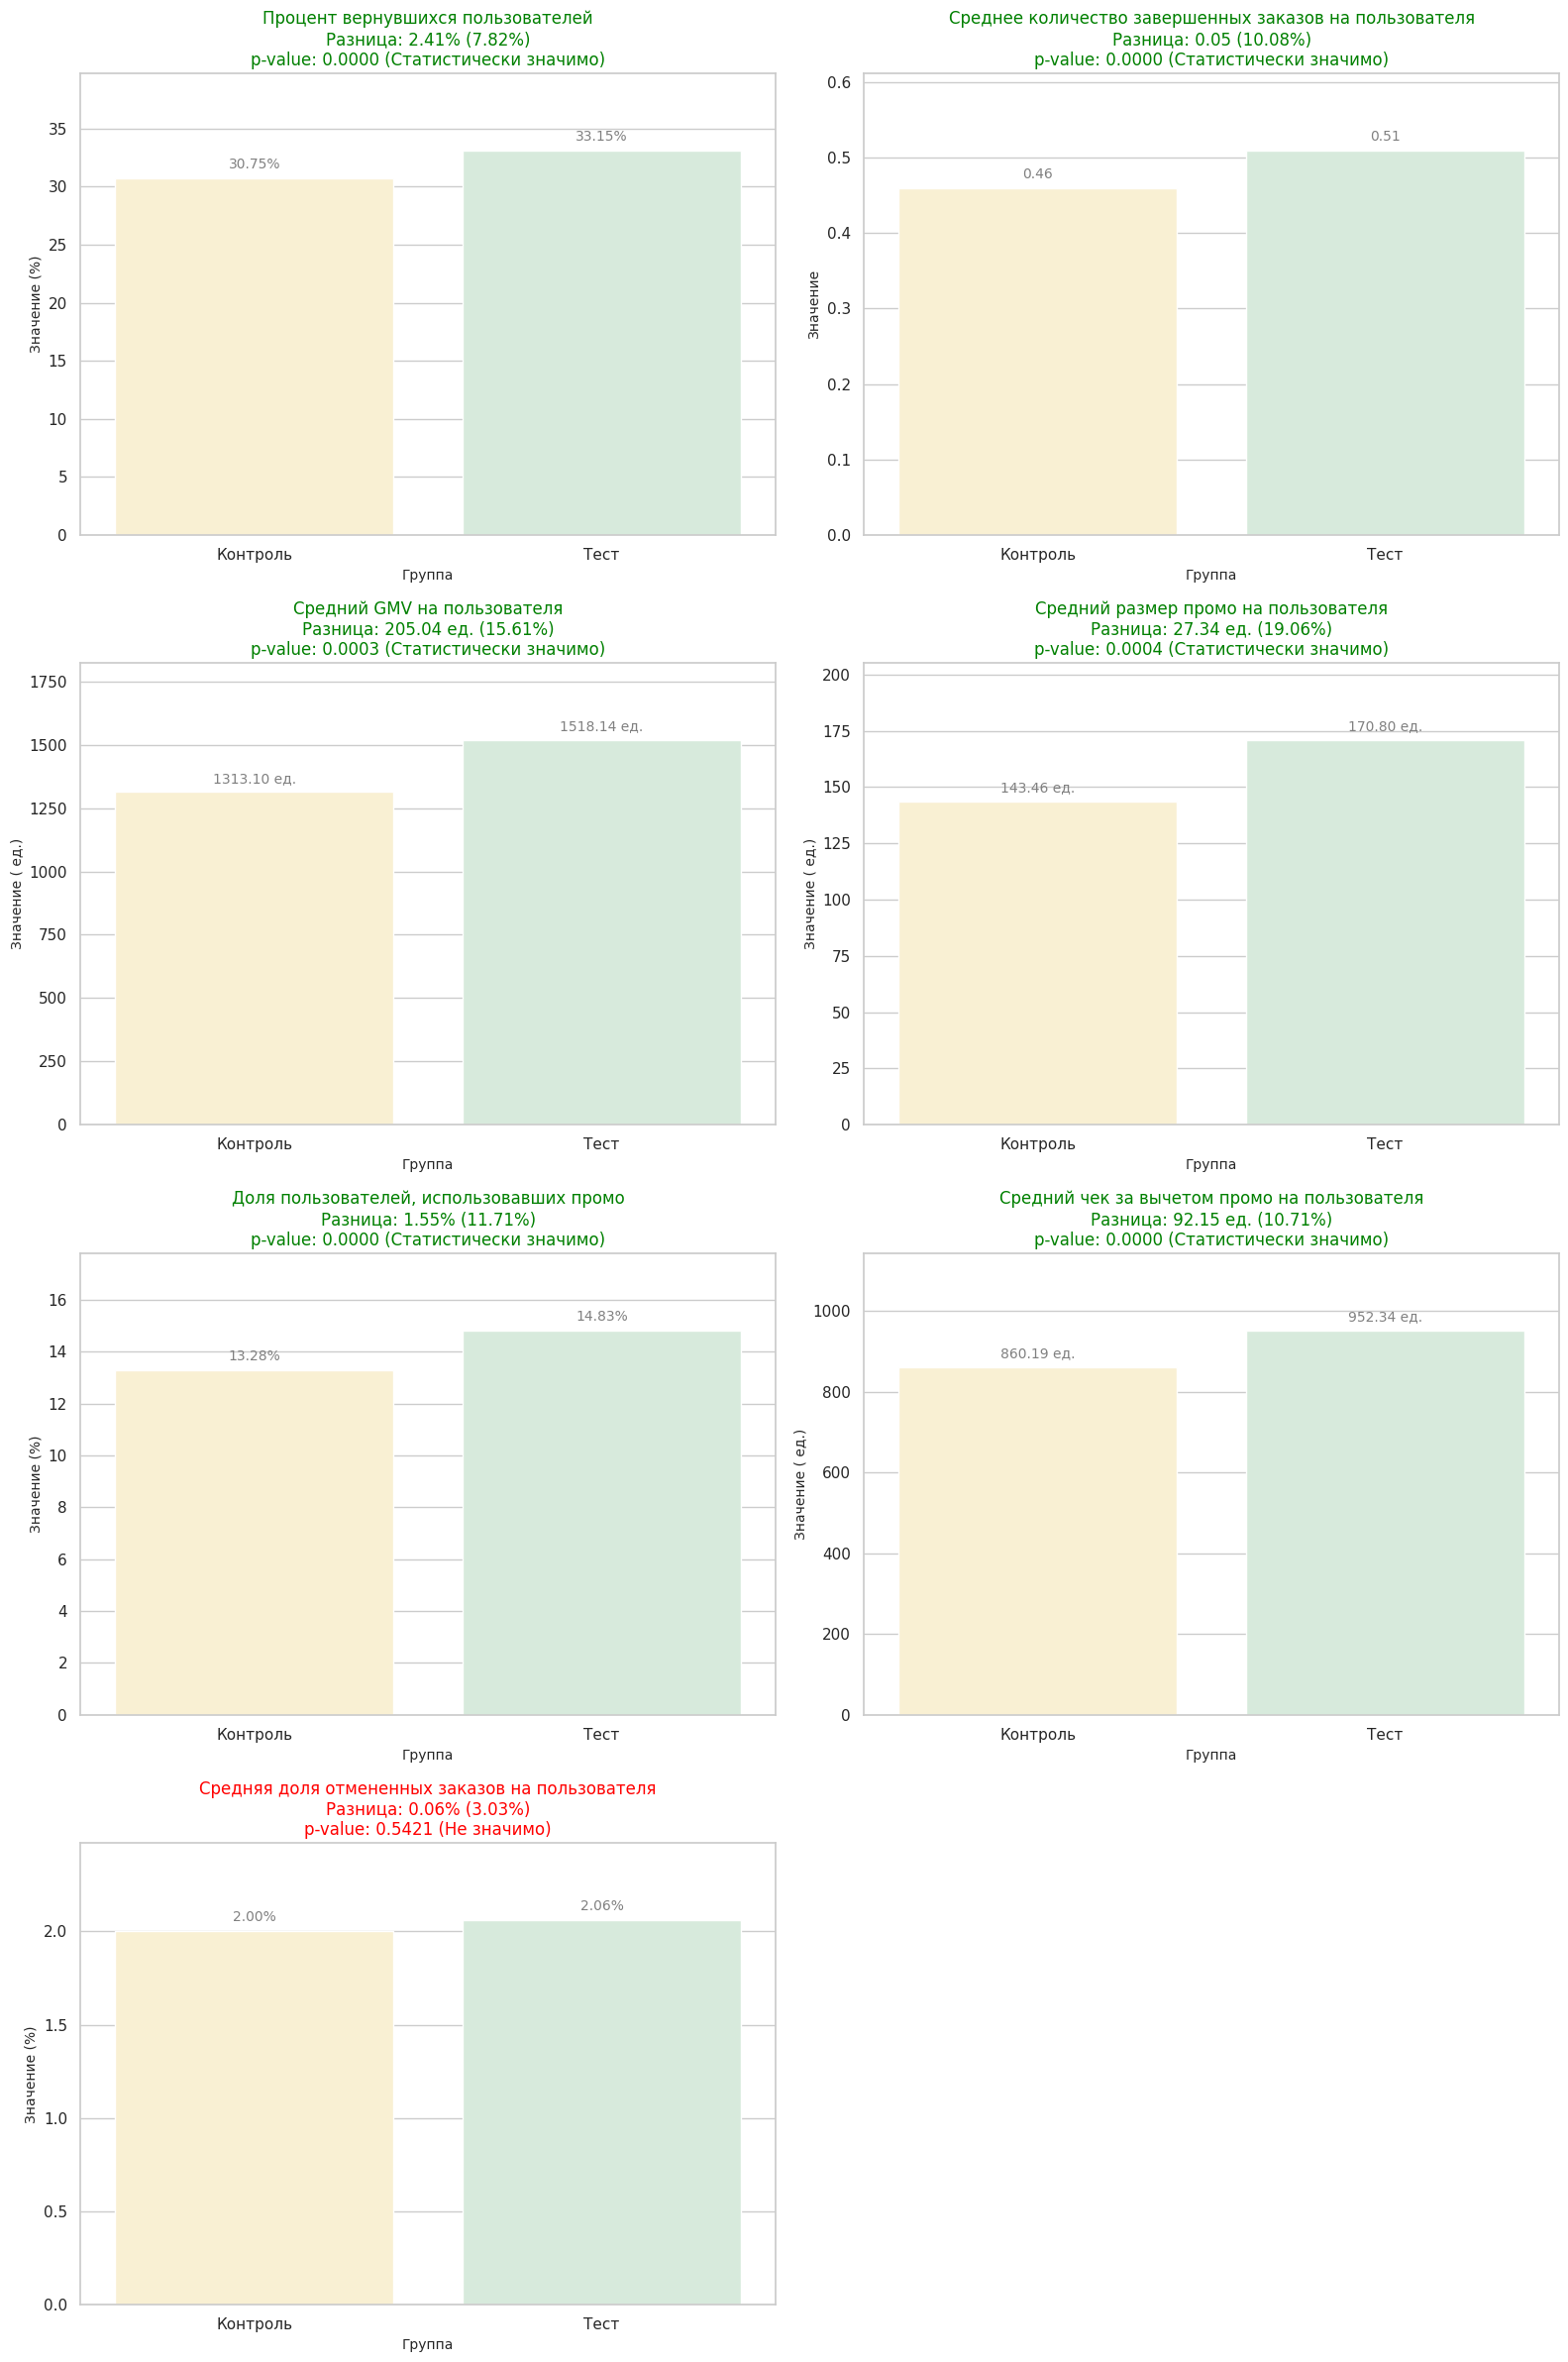

In [ ]:
# @title **Визуализация**
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import math # Для использования math.ceil

sns.set_theme()
sns.set_style("whitegrid")


results_data = {
    'Метрика': [
        'User Retention Rate',
        'Average Completed Orders per User',
        'Average GMV per User',
        'Average Promo per User',
        'Percentage of Users Who Used Promo',
        'Average Order Value per User (Net Promo)',
        'Average User Cancellation Rate'
    ],
    'Тест': [33.15, 0.51, 1518.14, 170.80, 14.83, 952.34, 2.06],
    'Контроль': [30.75, 0.46, 1313.10, 143.46, 13.28, 860.19, 2.00],
    'Разница (абс.)': [2.41, 0.05, 205.04, 27.34, 1.55, 92.15, 0.06],
    'Разница (%)': [7.82, 10.08, 15.61, 19.06, 11.71, 10.71, 3.03],
    'p-value': [0.0000, 0.0000, 0.0003, 0.0004, 0.0000, 0.0000, 0.5421]
}
results_df_from_table = pd.DataFrame(results_data)

alpha = 0.05 # Уровень значимости

# Определение метрик для визуализации
metrics_to_plot_info = [
    {'name': 'User Retention Rate', 'title': 'Процент вернувшихся пользователей', 'unit': '%'},
    {'name': 'Average Completed Orders per User', 'title': 'Среднее количество завершенных заказов на пользователя', 'unit': ''},
    {'name': 'Average GMV per User', 'title': 'Средний GMV на пользователя', 'unit': ' ед.'},
    {'name': 'Average Promo per User', 'title': 'Средний размер промо на пользователя', 'unit': ' ед.'},
    {'name': 'Percentage of Users Who Used Promo', 'title': 'Доля пользователей, использовавших промо', 'unit': '%'},
    {'name': 'Average Order Value per User (Net Promo)', 'title': 'Средний чек за вычетом промо на пользователя', 'unit': ' ед.'},
    {'name': 'Average User Cancellation Rate', 'title': 'Средняя доля отмененных заказов на пользователя', 'unit': '%'}
]

# Создание графиков


num_metrics = len(metrics_to_plot_info)
num_cols = 2
num_rows = math.ceil(num_metrics / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 6 * num_rows))
axes = axes.flatten() # Преобразуем 2D массив осей в 1D для удобной итерации


light_green = '#D4EDDA'
light_orange = '#FFF3CD'

for i, metric_info in enumerate(metrics_to_plot_info):
    metric_name = metric_info['name']
    plot_title = metric_info['title']
    unit = metric_info['unit']

    # Извлекаем данные для текущей метрики из DataFrame, созданного из таблицы
    current_metric_row = results_df_from_table[results_df_from_table['Метрика'] == metric_name].iloc[0]

    val_control = current_metric_row['Контроль']
    val_test = current_metric_row['Тест']
    diff = current_metric_row['Разница (абс.)']
    diff_perc = current_metric_row['Разница (%)']
    p_value = current_metric_row['p-value']

    # Создаем DataFrame для графика
    plot_df = pd.DataFrame({
        'Группа': ['Контроль', 'Тест'],
        'Значение': [val_control, val_test]
    })

    # Определяем цвета для баров на основе их значений
    bar_colors = []
    if val_test > val_control:
        bar_colors = [light_orange, light_green] # Контроль (ниже) - оранжевый, Тест (выше) - зеленый
    else: # val_control >= val_test
        bar_colors = [light_green, light_orange] # Контроль (выше или равен) - зеленый, Тест (ниже) - оранжевый


    ax = axes[i] # Выбираем текущую ось
    # ИСПРАВЛЕНО: Явно указываем hue='Группа' и legend=False
    sns.barplot(x='Группа', y='Значение', data=plot_df, ax=ax, palette=bar_colors, hue='Группа', legend=False)

    # Добавляем значения на бары
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}{unit}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10),
                    textcoords='offset points', fontsize=10, color='gray')

    # Добавляем информацию о разнице и p-value
    diff_text = f"Разница: {diff:.2f}{unit} ({diff_perc:.2f}%)" if not np.isnan(diff_perc) else "Разница: N/A"
    p_value_text = f"p-value: {p_value:.4f}" if not np.isnan(p_value) else "p-value: N/A"

    significance_indicator = ""
    title_color = 'black' # Цвет заголовка по умолчанию
    if not np.isnan(p_value):
        if p_value < alpha:
            significance_indicator = " (Статистически значимо)"
            title_color = 'green' # Зеленый для значимых результатов
        else:
            significance_indicator = " (Не значимо)"
            title_color = 'red' # Красный для не значимых результатов

    ax.set_title(f"{plot_title}\n{diff_text}\n{p_value_text}{significance_indicator}", fontsize=12, color=title_color) # Уменьшаем размер шрифта заголовка для подграфиков

    ax.set_ylabel(f"Значение ({unit})" if unit else "Значение", fontsize=10)
    ax.set_xlabel("Группа", fontsize=10)

    # Увеличиваем лимит Y для аннотаций, но с учетом минимального значения, чтобы не обрезать бары
    min_val = plot_df['Значение'].min()
    max_val = plot_df['Значение'].max()
    if min_val < 0:
        ax.set_ylim(min_val * 1.2, max_val * 1.2)
    else:
        ax.set_ylim(0, max_val * 1.2)

# Удаляем пустые подграфики, если количество метрик нечетное
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() # Обеспечивает, что элементы не перекрываются
plt.show()

# **Результаты A/B теста**

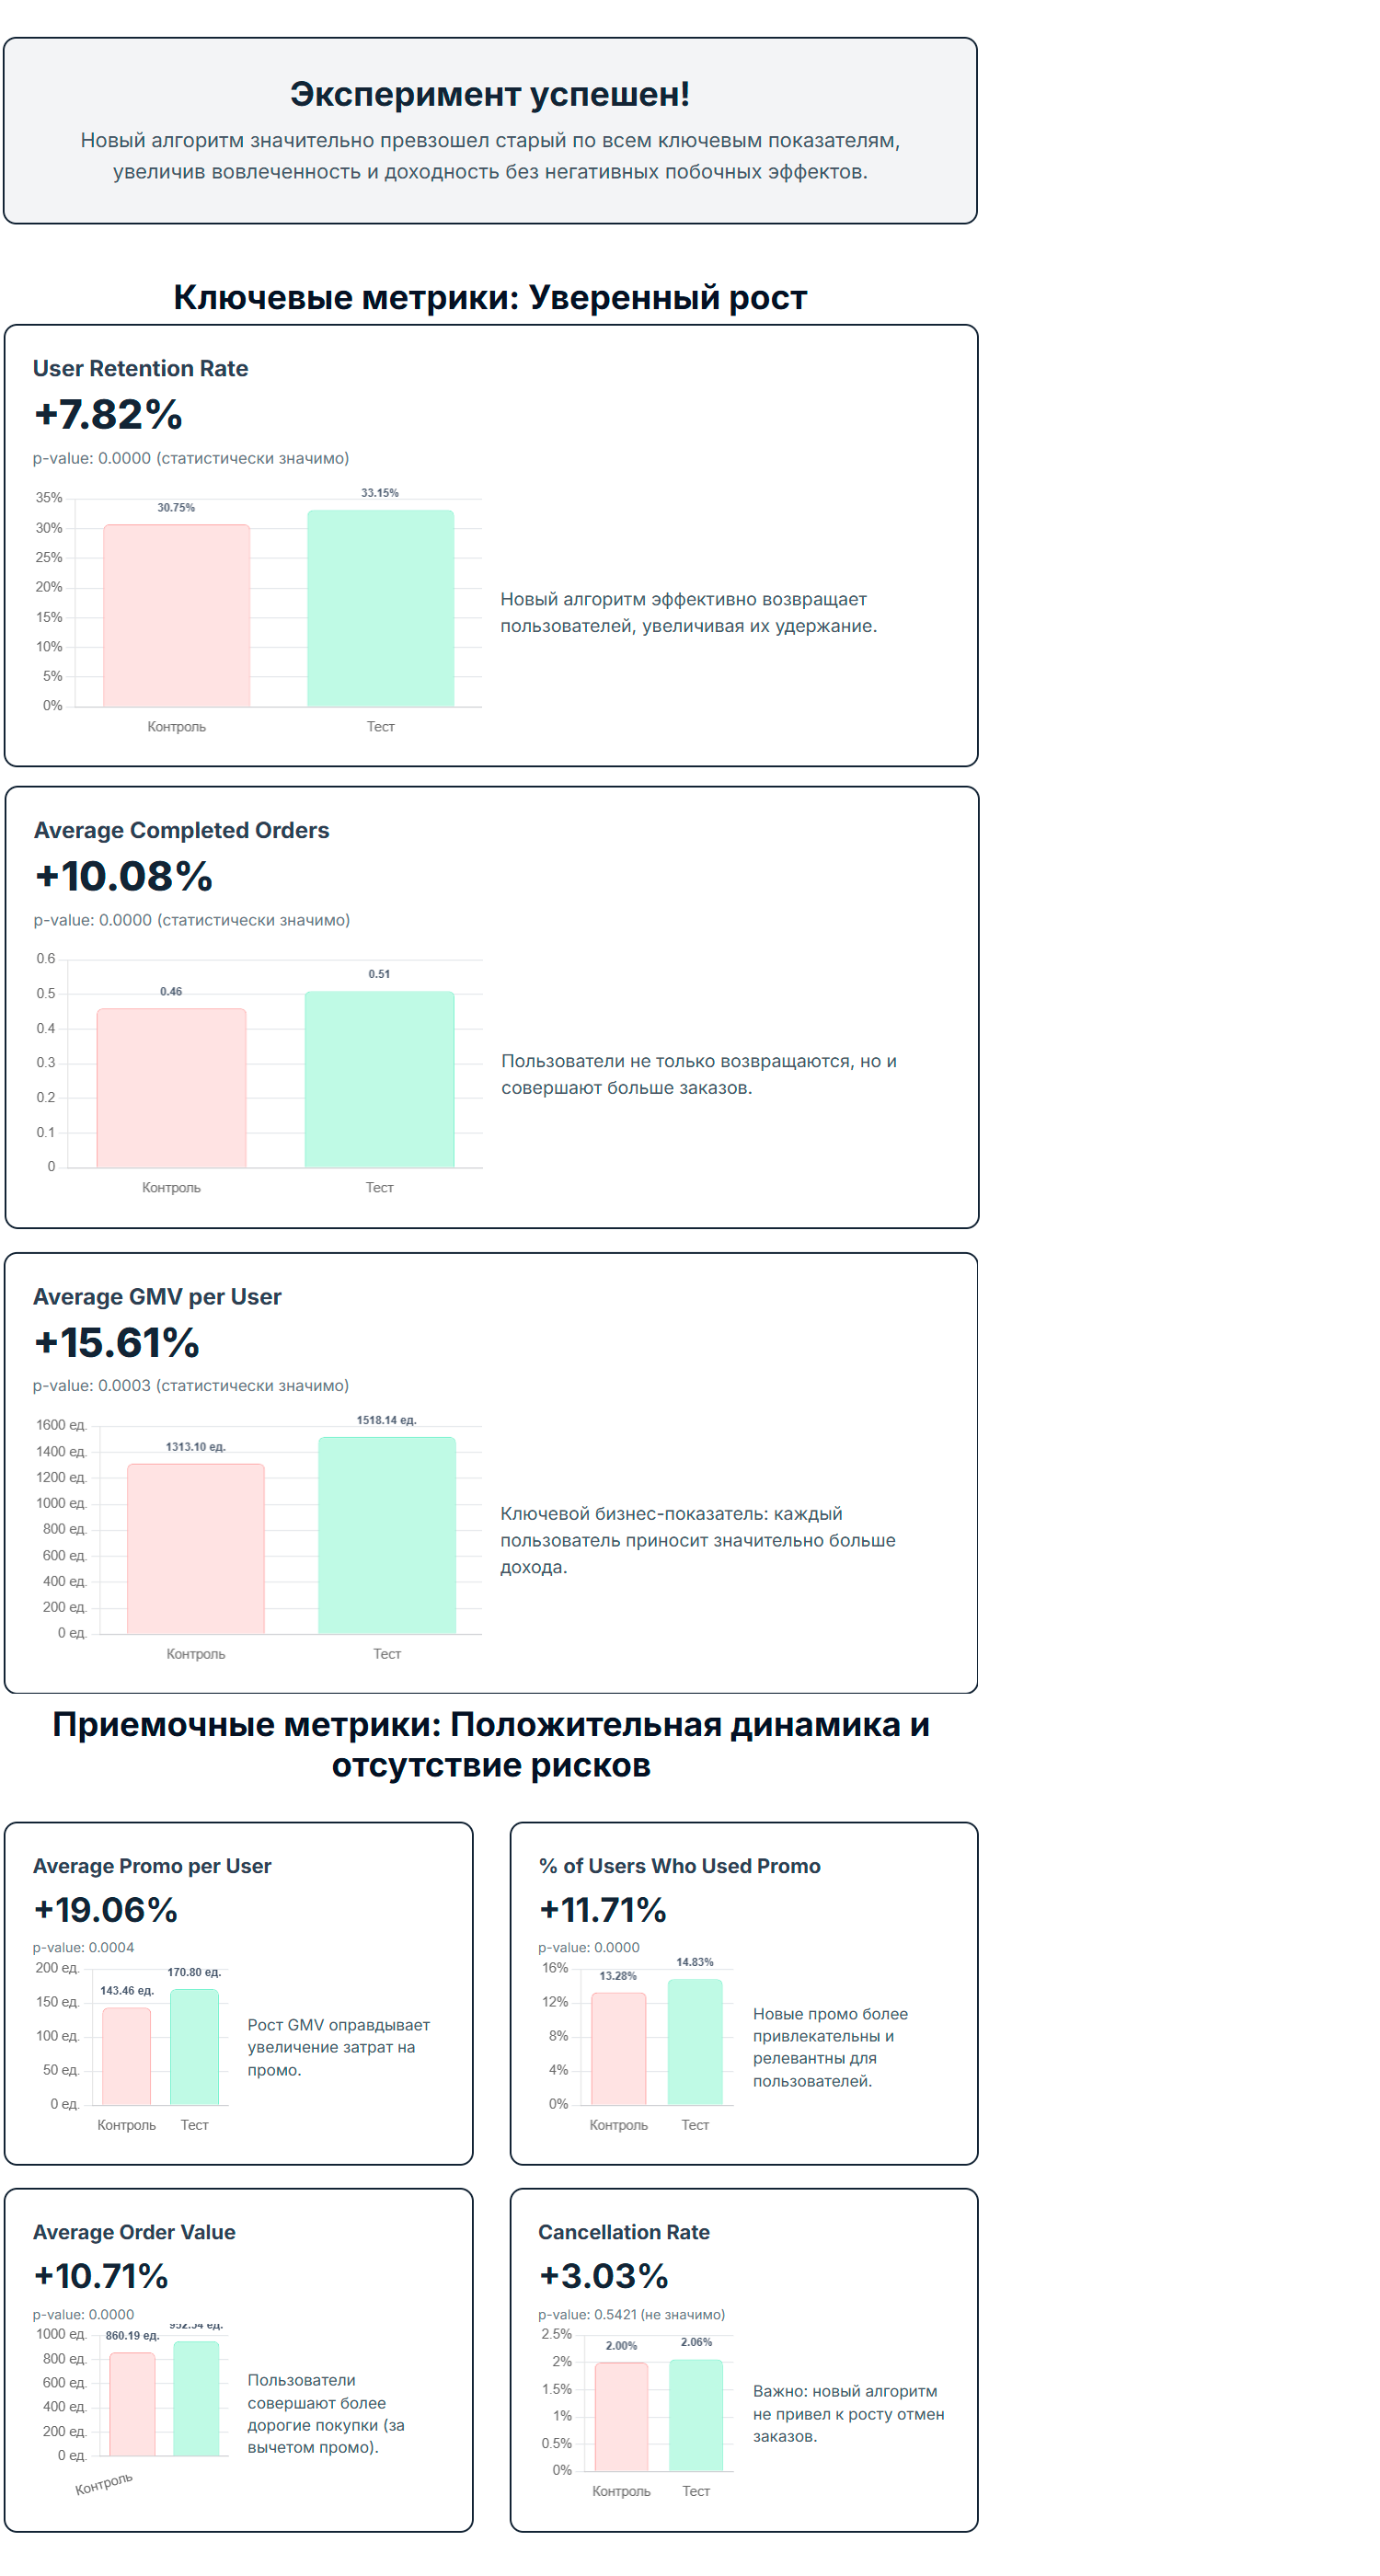

❗️На основе убедительных положительных результатов по всем ключевым метрикам и отсутствия негативных побочных эффектов, новый алгоритм подбора промокодов **рекомендуется к внедрению**.

# ▶▶▶НА ПРОВЕРКУ◀◀◀

**Гипотеза:**

Рассылка промокодов на реактивацию пользователей с использованием нового алгоритма, вероятно, улучшит ключевые показатели вовлеченности и дохода, такие как процент возврата пользователей, среднее количество завершенных заказов и общий объем продаж (GMV) на пользователя. При этом мы ожидаем, что это не приведет к значительному ухудшению приемочных метрик, таких как средний размер промо на пользователя или доля отмененных заказов, что обеспечит положительный возврат инвестиций.

**Ключевые метрики:**
  - User Retention Rate: Доля уникальных пользователей, совершивших хотя бы один успешный заказ после реактивации.

  - Average Completed Orders per User: Общее количество завершенных заказов в группе, деленное на общее количество уникальных пользователей.

  - Average GMV per User: Суммарный GMV всех пользователей в группе за вычетом промо, деленный на общее количество уникальных пользователей.

**Приемочные метрики:**
  - Average Promo per User: Общая сумма всех примененных промокодов в группе, деленная на общее количество уникальных пользователей.

  - Percentage of Users Who Used Promo: Количество уникальных пользователей, использовавших промо, деленное на общее количество уникальных пользователей в группе.

  - Cancellation Rate: Общее количество отмененных заказов в группе, деленное на общее количество всех заказов в группе.

  - Average User Cancellation Rate: Средняя доля отмененных заказов на пользователя.

In [ ]:
print(mde_df.to_string(index=False))

                                 Метрика Базовое значение   Дисперсия MDE (абс.) MDE (%)
                     User Retention Rate  0.9705 (97.05%)      0.0287     0.0029   0.30%
           Avg Completed Orders per User             1.29        0.68       0.01   1.09%
                    Average GMV per User          2949.94 33203162.36      98.88   3.35%
                  Average Promo per User           446.49  1517300.89      21.14   4.73%
      Percentage of Users Who Used Promo  0.4369 (43.69%)      0.2460     0.0085   1.95%
Average Order Value per User (Net Promo)          2206.97 12964992.81      61.79   2.80%
          Average User Cancellation Rate   0.0501 (5.01%)      0.0368     0.0033   6.56%


In [ ]:
display(styled_results)

,Метрика,Тест,Контроль,Разница (абс.),Разница (%),p-value
0,User Retention Rate,33.15,30.75,2.41,7.82%,0.0000
1,Average Completed Orders per User,0.51,0.46,0.05,10.08%,0.0000
2,Average GMV per User,1518.14,1313.10,205.04,15.61%,0.0003
3,Average Promo per User,170.80,143.46,27.34,19.06%,0.0004
4,Percentage of Users Who Used Promo,14.83,13.28,1.55,11.71%,0.0000
5,Average Order Value per User (Net Promo),952.34,860.19,92.15,10.71%,0.0000
6,Average User Cancellation Rate,2.06,2.00,0.06,3.03%,0.5421
